In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
import numpy as np
import tqdm as notebook_tqdm
import emoji
import seaborn as sns
import os
import torch
from umap.umap_ import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.vectorizers import ClassTfidfTransformer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from bertopic.representation import KeyBERTInspired
from bertopic.representation import MaximalMarginalRelevance
from sklearn.metrics.pairwise import cosine_similarity
import re
import plotly.io as pio
from datetime import datetime
from scipy.stats import zscore

In [4]:
topic_model = BERTopic.load("bertopic_model")

In [9]:
df = pd.read_csv("document_topic_theme_assignments_with_ids.csv")

In [10]:
df

,comment_id,Document,Topic,Timestamp,quarter,score,Theme
0,md8mlm6,"Chill bro, my wife is on here",31,2025-02-17 12:44:54,2025-01-01,78.0,NaN
1,md7zvec,Solid facial gains! How was your diet?,-1,2025-02-17 09:10:25,2025-01-01,73.0,NaN
2,md845a7,"Impressive! I can only hope, that I can presen...",16,2025-02-17 09:54:30,2025-01-01,27.0,General Diet and Nutrition Discussion
3,md93t4g,Stop lying. That's not the same person. Looks ...,8,2025-02-17 14:35:12,2025-01-01,14.0,Community Building
4,md847sx,Bro is a model now. Congrats! Looking good!,-1,2025-02-17 09:55:12,2025-01-01,11.0,NaN
...,...,...,...,...,...,...,...
360155,l3grtl0,"Any truth to this in peat world? ""Research sug...",14,2024-05-10 18:14:09,2024-04-01,1.0,NaN
360156,l3hrxcl,What about cheeses?,42,2024-05-10 21:56:03,2024-04-01,1.0,Food Choice Discussion
360157,m4bmv8u,"Sounds like candida to me, carbs feed it",-1,2024-12-29 07:20:59,2024-10-01,1.0,NaN
360158,l3cytbl,you may want to look into /u/exfatloss 's diet...,14,2024-05-09 23:56:05,2024-04-01,0.0,NaN


In [11]:
# Ensure Timestamp is datetime (if not already)
df["Timestamp"] = pd.to_datetime(df["Timestamp"])

# Filter: only keep rows with a valid theme and within the 2013–2024 range
df = df[df["Theme"].notna()]
df = df[(df["Timestamp"] >= "2013-01-01") & (df["Timestamp"] <= "2024-12-31")]

In [6]:
len(df)

145083

total comments before time filtering: 163,648

# Over time

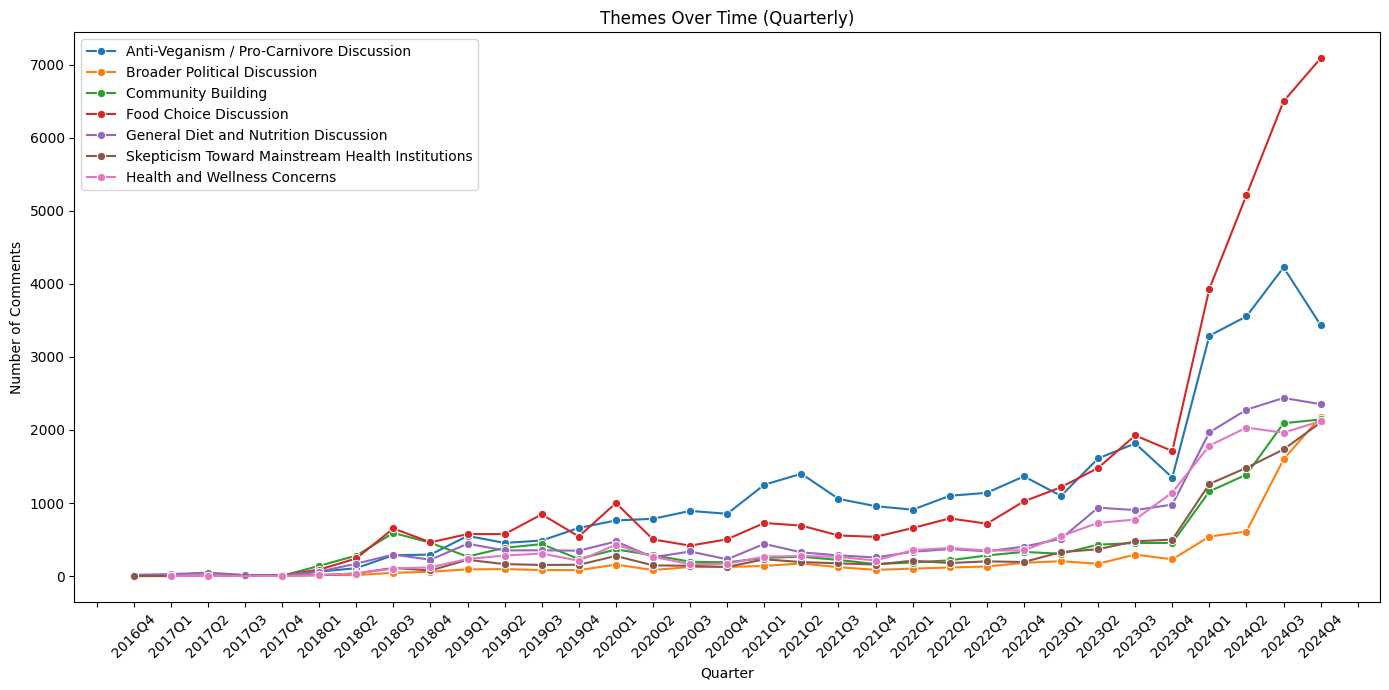

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Ensure Timestamp is in datetime and quarter format
df["quarter"] = df["Timestamp"].dt.to_period("Q")

# Count number of comments per theme per quarter
theme_over_time = df.groupby(["quarter", "Theme"]).size().reset_index(name="count")

# Convert quarter to string (e.g., "2021Q4") for plotting
theme_over_time["quarter_str"] = theme_over_time["quarter"].astype(str)

# Plot
plt.figure(figsize=(14, 7))
sns.lineplot(
    data=theme_over_time,
    x="quarter_str",  # Use string representation for proper labeling
    y="count",
    hue="Theme",
    marker="o"
)

plt.title("Themes Over Time (Quarterly)")
plt.xlabel("Quarter")
plt.ylabel("Number of Comments")

# Rotate X-axis labels for better readability
plt.xticks(rotation=45)

# Ensure all quarters are displayed (optional: skip some if too dense)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(40))  # Adjust number of ticks if needed

plt.tight_layout()
plt.legend()
plt.show()

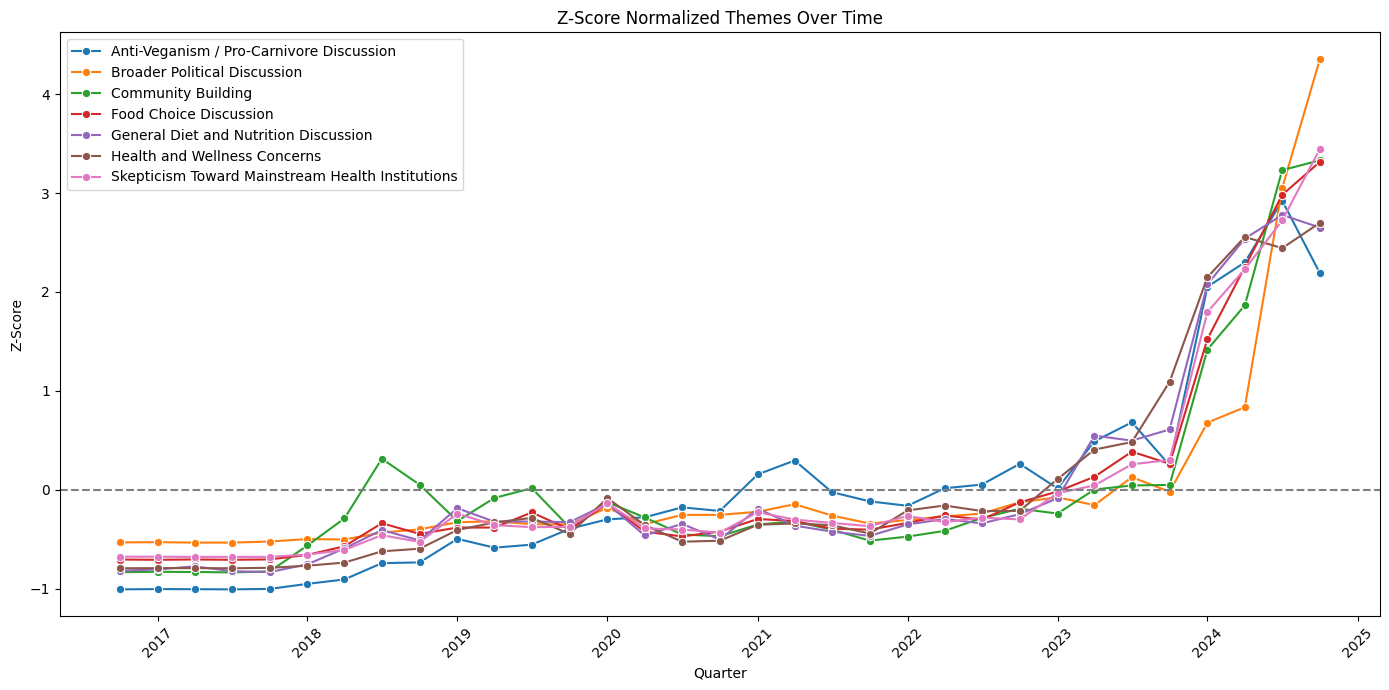

In [51]:
# Count number of comments per theme per quarter
theme_over_time = df.groupby(["quarter", "Theme"]).size().reset_index(name="count")

# Pivot to wide format (each theme gets a column)
theme_pivot = theme_over_time.pivot(index="quarter", columns="Theme", values="count").fillna(0)

# Normalize with z-scores (by column, i.e., per theme)
theme_zscores = theme_pivot.apply(zscore, nan_policy='omit')

# Convert back to long format for plotting
theme_zscores_long = theme_zscores.reset_index().melt(id_vars="quarter", var_name="Theme", value_name="zscore")

# Plot
plt.figure(figsize=(14, 7))
sns.lineplot(data=theme_zscores_long, x="quarter", y="zscore", hue="Theme", marker="o")
plt.title("Z-Score Normalized Themes Over Time")
plt.xlabel("Quarter")
plt.ylabel("Z-Score")
plt.xticks(rotation=45)
plt.axhline(0, color="gray", linestyle="--")
plt.tight_layout()
plt.legend()
plt.show()

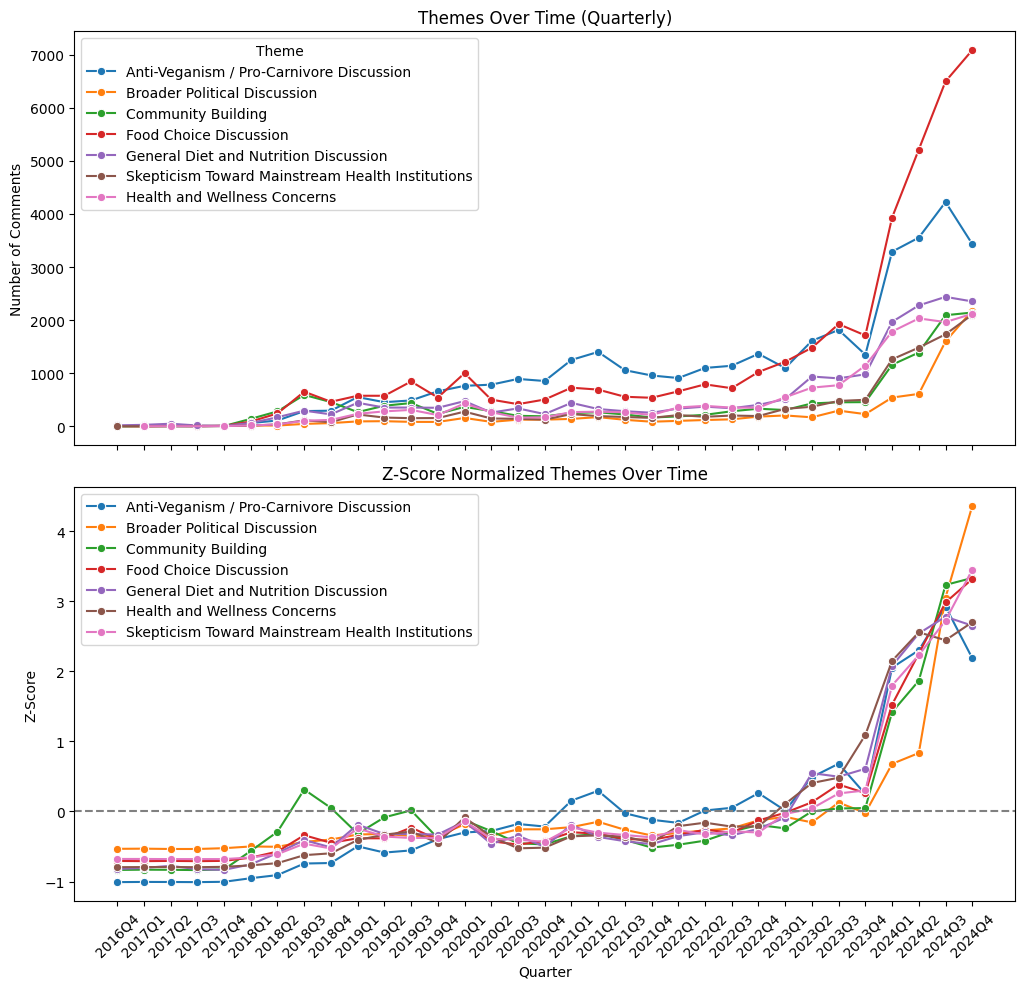

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import zscore

# Ensure Timestamp is in datetime and quarter format
df["Timestamp"] = pd.to_datetime(df["Timestamp"])
df["quarter"] = df["Timestamp"].dt.to_period("Q")

# Count number of comments per theme per quarter
theme_over_time = df.groupby(["quarter", "Theme"]).size().reset_index(name="count")
theme_over_time["quarter_str"] = theme_over_time["quarter"].astype(str)

# Pivot to wide format for z-score normalization
theme_pivot = theme_over_time.pivot(index="quarter", columns="Theme", values="count").fillna(0)
theme_zscores = theme_pivot.apply(zscore, nan_policy='omit')

# Convert z-scores back to long format
theme_zscores_long = theme_zscores.reset_index().melt(id_vars="quarter", var_name="Theme", value_name="zscore")
theme_zscores_long["quarter_str"] = theme_zscores_long["quarter"].astype(str)

# Set up a taller and narrower figure with two subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# --- Plot 1: Raw comment counts ---
sns.lineplot(
    data=theme_over_time,
    x="quarter_str",
    y="count",
    hue="Theme",
    marker="o",
    ax=axes[0]
)
axes[0].set_title("Themes Over Time (Quarterly)")
axes[0].set_ylabel("Number of Comments")
axes[0].tick_params(axis='x', rotation=45)

# --- Plot 2: Z-score normalized trends ---
sns.lineplot(
    data=theme_zscores_long,
    x="quarter_str",
    y="zscore",
    hue="Theme",
    marker="o",
    ax=axes[1]
)
axes[1].axhline(0, color="gray", linestyle="--")
axes[1].set_title("Z-Score Normalized Themes Over Time")
axes[1].set_ylabel("Z-Score")
axes[1].set_xlabel("Quarter")
axes[1].tick_params(axis='x', rotation=45)

# Layout
plt.tight_layout()
plt.legend()
plt.subplots_adjust(right=0.85)
plt.show()


In [33]:
# Ensure Timestamp is in datetime format and convert to quarter
df["Timestamp"] = pd.to_datetime(df["Timestamp"])
df["quarter"] = df["Timestamp"].dt.to_period("Q")

# Filter for 2024Q4
df_2024q4 = df[df["quarter"] == "2024Q4"]

# Drop NaN themes (optional: depends on whether you want to count them)
df_2024q4 = df_2024q4.dropna(subset=["Theme"])

# Count comments per theme
theme_counts = df_2024q4["Theme"].value_counts().reset_index()
theme_counts.columns = ["Theme", "Count"]

# Calculate percentage of total
theme_counts["Percentage"] = (theme_counts["Count"] / theme_counts["Count"].sum() * 100).round(2)

# Display result
print(theme_counts)


                                              Theme  Count  Percentage
0                            Food Choice Discussion   7086       33.09
1          Anti-Veganism / Pro-Carnivore Discussion   3434       16.03
2             General Diet and Nutrition Discussion   2352       10.98
3                      Broader Political Discussion   2180       10.18
4                                Community Building   2143       10.01
5                      Health and Wellness Concerns   2119        9.89
6  Skepticism Toward Mainstream Health Institutions   2102        9.82


# Scores

In [54]:
theme_scores = df.dropna(subset=["Theme"])

# Calculate average and median score per theme
score_stats = theme_scores.groupby("Theme")["score"].agg(["count", "mean", "median", "std", "min", "max"]).sort_values("mean", ascending=False)

print(score_stats)

                                                  count      mean  median  \
Theme                                                                       
Anti-Veganism / Pro-Carnivore Discussion          35758  7.154343     3.0   
Broader Political Discussion                       7865  6.665099     3.0   
Skepticism Toward Mainstream Health Institutions  11413  5.669763     2.0   
Food Choice Discussion                            41187  5.179426     2.0   
Community Building                                14185  4.591963     2.0   
Health and Wellness Concerns                      15897  4.566270     2.0   
General Diet and Nutrition Discussion             18778  4.159016     2.0   

                                                        std   min    max  
Theme                                                                     
Anti-Veganism / Pro-Carnivore Discussion          13.623874 -82.0  299.0  
Broader Political Discussion                      16.059045 -56.0  359.0  
Skepti

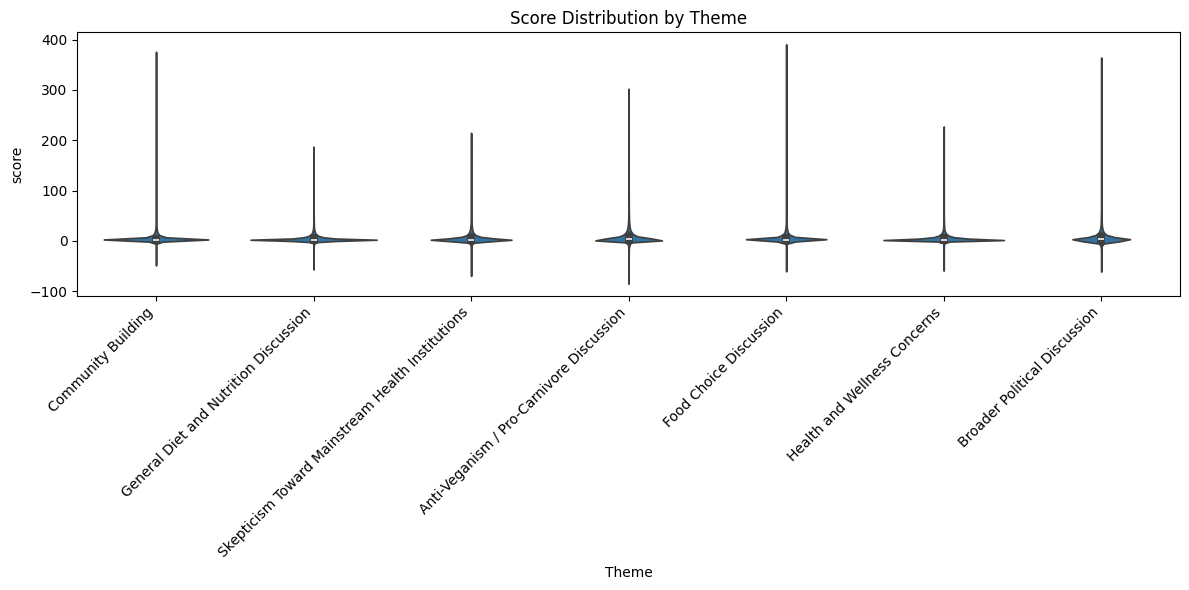

In [57]:
plt.figure(figsize=(12, 6))
sns.violinplot(data=theme_scores, x="Theme", y="score")
plt.xticks(rotation=45, ha="right")
plt.title("Score Distribution by Theme")
plt.tight_layout()
plt.show()

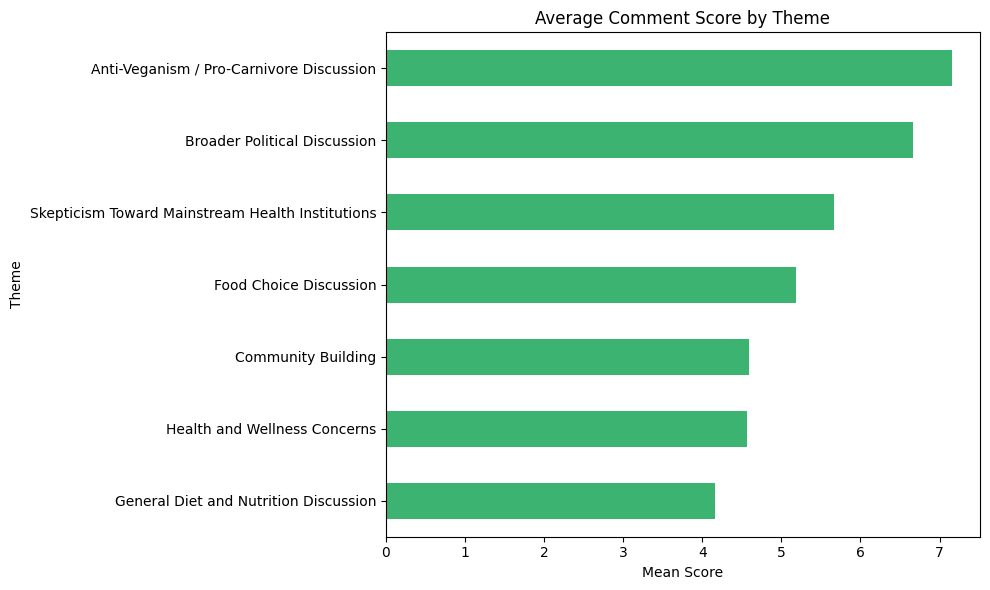

In [59]:
# Calculate mean score per theme
mean_scores = df.dropna(subset=["Theme"]).groupby("Theme")["score"].mean().sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
mean_scores.plot(kind="barh", color="mediumseagreen")
plt.xlabel("Mean Score")
plt.title("Average Comment Score by Theme")
plt.gca().invert_yaxis()  # Highest mean on top
plt.tight_layout()
plt.show()


In [62]:
# Drop rows without a theme or score
df_filtered = df.dropna(subset=["Theme", "score"])

# Get top 3 scoring comments per theme (you can change nlargest to any number)
top_comments = (
    df_filtered.sort_values("score", ascending=False)
    .groupby("Theme")
    .head(5)
    .sort_values(["Theme", "score"], ascending=[True, False])
)

# Display full comments
for theme, group in top_comments.groupby("Theme"):
    print(f"\n--- {theme} ---")
    for _, row in group.iterrows():
        print(f"Score: {int(row['score'])} | Comment: {row['Document']}")



--- Anti-Veganism / Pro-Carnivore Discussion ---
Score: 299 | Comment: Punishing your kids for trying new foods is a very quick way to give them eating disorders and other issues. Ask me how I know.
Score: 280 | Comment: Honestly, that's borderline child abuse. Punishing a child for eating non-vegan food.
Score: 258 | Comment: By using their nonhuman digestive systems to extract amino acids from plants.
Score: 253 | Comment: Maybe don't wear your good clothes when cooking. Or maybe put an apron on.
Score: 245 | Comment: if your husband cares more about veganism than the physical well-being of his wife, then you gotta just throw the whole husband out, smh

--- Broader Political Discussion ---
Score: 359 | Comment: Should be in Jail for that
Score: 357 | Comment: Not wanting to kill your liver with lineolic acid shouldn't be a political issue. For decades liberals have been all about that soy. I'm glad people are finally waking up.
Score: 356 | Comment: let's hope RFK makes America heal

# Most common words and phrases

In [2]:
from collections import Counter
import nltk 
from nltk.corpus import stopwords

In [3]:
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\arvin\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [8]:
# Drop rows without theme
df_filtered = df.dropna(subset=["Theme"])

# Function to clean and tokenize text
def tokenize(text):
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)  # remove punctuation
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    return tokens

# Get most common words per theme
top_words_per_theme = {}

for theme, group in df_filtered.groupby("Theme"):
    all_tokens = []
    for text in group["Document"]:
        tokens = tokenize(str(text))
        all_tokens.extend(tokens)
    word_counts = Counter(all_tokens)
    top_words = word_counts.most_common(10)
    top_words_per_theme[theme] = top_words

# Print results
for theme, words in top_words_per_theme.items():
    print(f"\n--- {theme} ---")
    for word, count in words:
        print(f"{word}: {count}")


--- Anti-Veganism / Pro-Carnivore Discussion ---
vegan: 12885
meat: 11201
like: 8996
people: 8805
dont: 8227
eat: 8069
diet: 8027
carnivore: 6761
vegans: 6276
animals: 5810

--- Broader Political Discussion ---
people: 1357
like: 1127
trump: 941
dont: 912
rfk: 765
think: 753
would: 737
right: 668
one: 616
hes: 569

--- Community Building ---
beef: 1889
like: 1824
good: 1708
get: 1474
meat: 1342
steak: 1283
dont: 1255
thats: 1213
great: 1051
eat: 1027

--- Food Choice Discussion ---
oil: 10367
seed: 8406
like: 7963
oils: 7674
dont: 6138
eat: 5795
get: 4496
good: 4263
people: 4051
also: 3880

--- General Diet and Nutrition Discussion ---
fat: 5111
like: 4659
diet: 4447
eat: 4317
dont: 4043
keto: 3478
also: 3424
get: 3393
eating: 3315
much: 3252

--- Health and Wellness Concerns ---
like: 3868
dont: 3077
fat: 3076
pufa: 2992
also: 2982
get: 2805
diet: 2788
would: 2447
people: 2425
think: 2341

--- Skepticism Toward Mainstream Health Institutions ---
people: 2759
like: 1984
dont: 1917
foo

# Most common foods

In [14]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,173420,-1_vegans_carbs_protein_beef,"[vegans, carbs, protein, beef, carnivore, vega...",[These are my current raw meals to give you an...
1,0,14608,0_seed oils_oils_seed oil_olive oil,"[seed oils, oils, seed oil, olive oil, canola ...",[What were you looking at that had seed oils i...
2,1,13370,1_vegans_veganism_vegan_vegan diet,"[vegans, veganism, vegan, vegan diet, animals,...",[I am a recent vegan as well. After a year and...
3,2,12355,2_bacon_raw meat_carnivore diet_carnivores,"[bacon, raw meat, carnivore diet, carnivores, ...","[Cremated bacon, Well done my carnivore friend..."
4,3,6015,3_keto_carbs_ketosis_carb,"[keto, carbs, ketosis, carb, ketogenic, low ca...","[You mentioned keto. Have you seen this group,..."
...,...,...,...,...,...
145,144,111,144_yes does_does thanks_sure does_does does,"[yes does, does thanks, sure does, does does, ...","[Yes it does., Yes it does, Yes it does.]"
146,145,110,145_illegal_canada_belgium_legality,"[illegal, canada, belgium, legality, laws, leg...","[This should be illegal, This should be illega..."
147,146,110,146_tall_height_male_taller,"[tall, height, male, taller, age height, ve gr...","[How tall are you?, How tall are you?, is it e..."
148,147,108,147_rule_don jerk_rule don_rules,"[rule, don jerk, rule don, rules, jerk, thanks...",[Please see Rule #4 and it's description. It s...


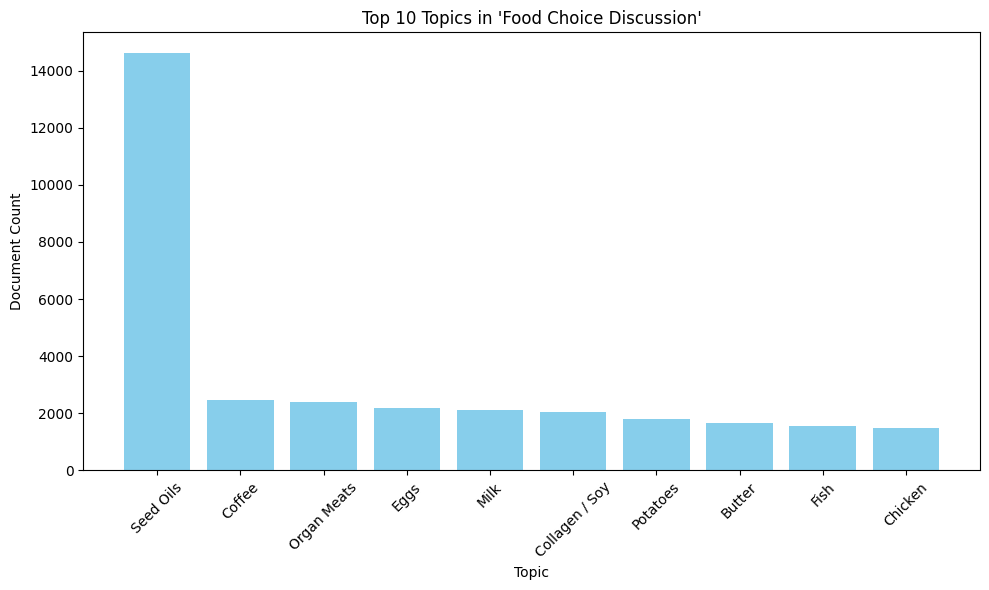

In [32]:

# Define topic names manually
topic_labels = {
    0: "Seed Oils",
    18: "Coffee",
    19: "Organ Meats",
    20: "Eggs",
    21: "Milk",
    22: "Collagen / Soy",
    23: "Potatoes",
    25: "Butter",
    29: "Fish",
    30: "Chicken"
}

# Load topic info and filter relevant topics
topic_info = topic_model.get_topic_info()
food_choice_topics = list(topic_labels.keys())
food_choice_info = topic_info[topic_info["Topic"].isin(food_choice_topics)]

# Map labels and sort by count
food_choice_info["Label"] = food_choice_info["Topic"].map(topic_labels)
top10 = food_choice_info.sort_values(by="Count", ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 6))
plt.bar(top10["Label"], top10["Count"], color="skyblue")
plt.xlabel("Topic")
plt.ylabel("Document Count")
plt.title("Top 10 Topics in 'Food Choice Discussion'")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Comment depth

In [13]:
# Load the full comment data
comments_full = pd.read_csv("comments_final.csv", index_col=0)

# Merge on comment_id instead of text
df = df.merge(
    comments_full[["comment_id", "author", "depth"]],
    on="comment_id",
    how="left"
)

In [25]:
df

,comment_id,Document,Topic,Timestamp,quarter,score,Theme,author,depth
0,l36kww4,You are an inspiration! This diet truly feels ...,8,2024-05-08 20:23:37,2024-04-01,85.0,Community Building,Theinternetdumbens,0.0
1,l37bj7t,A tip for the electrolytes: Get a good free fo...,4,2024-05-08 23:01:35,2024-04-01,15.0,General Diet and Nutrition Discussion,NaN,0.0
2,l36pnbm,Holy shit that’s amazing!!!!!!,49,2024-05-08 20:49:41,2024-04-01,13.0,Community Building,fistofbruce,0.0
3,l36m7qu,You look amazing!!! I hope I look as good as y...,8,2024-05-08 20:30:38,2024-04-01,20.0,Community Building,NaN,0.0
4,l36w7ay,This is so awesome 🥰🥰🥰,49,2024-05-08 21:26:11,2024-04-01,6.0,Community Building,Puzzled_Draw4820,0.0
...,...,...,...,...,...,...,...,...,...
145078,l3e1xgi,I would try and research how to reverse lactos...,21,2024-05-10 04:52:17,2024-04-01,2.0,Food Choice Discussion,scottywottytotty,0.0
145079,l3eo4jq,Histamine. I’ll make a strict elimination diet...,80,2024-05-10 09:15:14,2024-04-01,2.0,Health and Wellness Concerns,NaN,0.0
145080,l3cviqj,"You didn't mention alcohol, do you drink? Do a...",2,2024-05-09 23:33:57,2024-04-01,1.0,Anti-Veganism / Pro-Carnivore Discussion,PipeTobacco33,0.0
145081,l3hrxcl,What about cheeses?,42,2024-05-10 21:56:03,2024-04-01,1.0,Food Choice Discussion,NaN,0.0


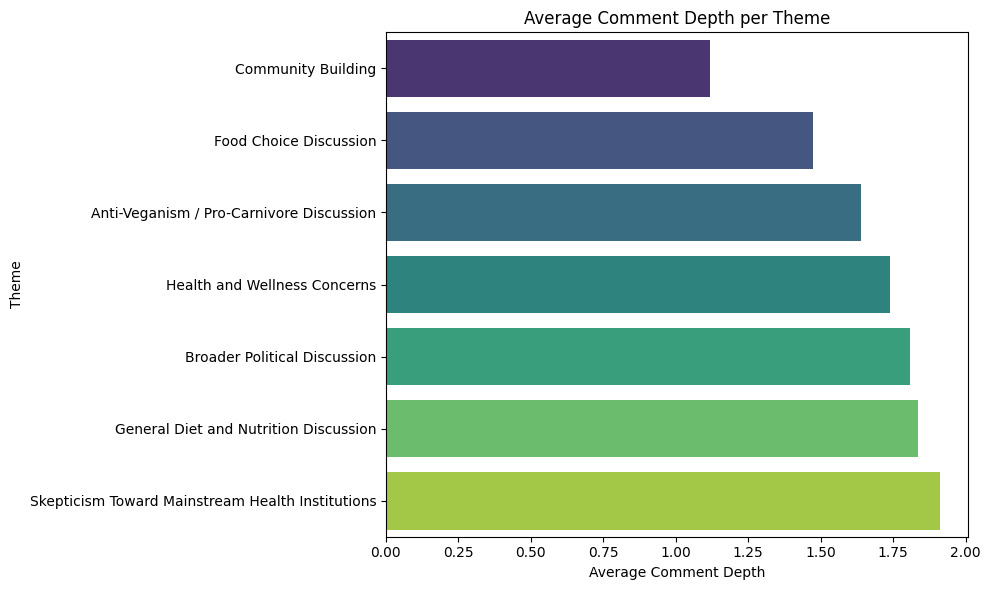

In [14]:
# Drop rows with missing values in 'Theme' or 'depth'
df_depth = df.dropna(subset=["Theme", "depth"])

# Calculate average depth per theme
avg_depth = df_depth.groupby("Theme")["depth"].mean().sort_values()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=avg_depth.values, y=avg_depth.index, palette="viridis")
plt.xlabel("Average Comment Depth")
plt.ylabel("Theme")
plt.title("Average Comment Depth per Theme")
plt.tight_layout()
plt.show()

# Authors

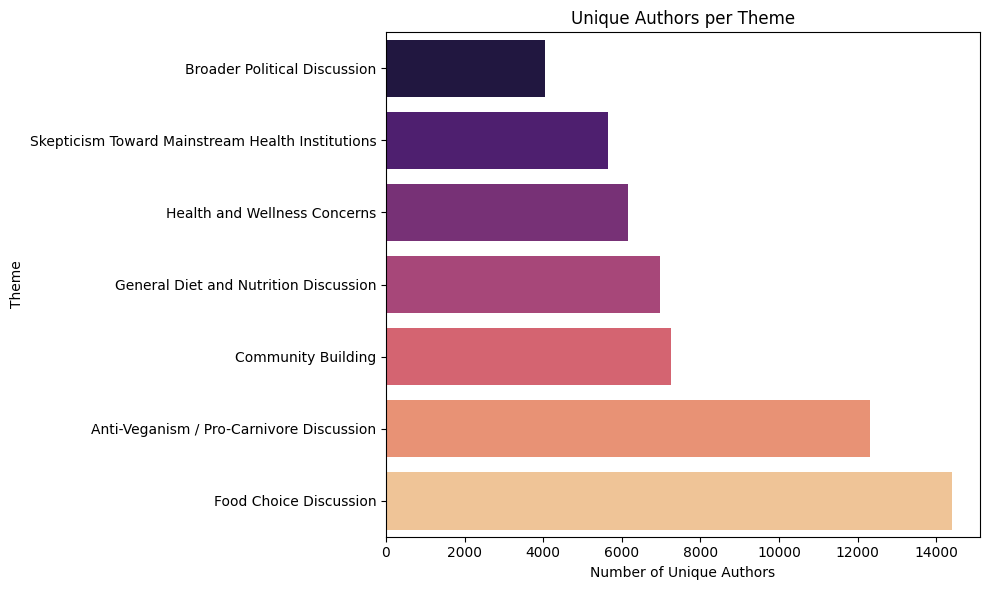

In [15]:
authors_per_theme = df.dropna(subset=["Theme", "author"]).groupby("Theme")["author"].nunique().sort_values()

plt.figure(figsize=(10, 6))
sns.barplot(x=authors_per_theme.values, y=authors_per_theme.index, palette="magma")
plt.xlabel("Number of Unique Authors")
plt.ylabel("Theme")
plt.title("Unique Authors per Theme")
plt.tight_layout()
plt.show()


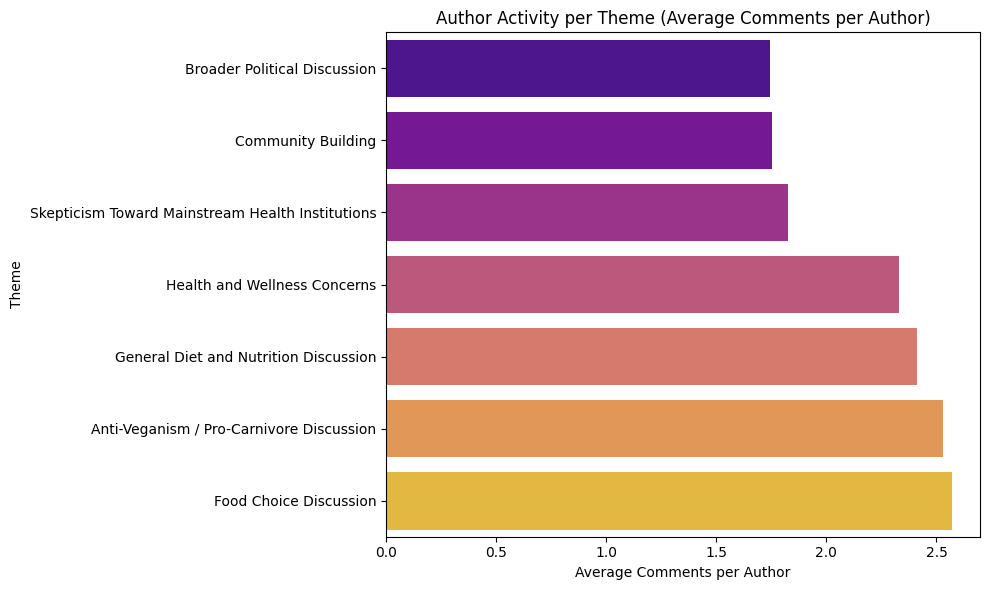

In [16]:
# Group by theme and author, then count comments
author_comment_counts = df.dropna(subset=["Theme", "author"]).groupby(["Theme", "author"]).size().reset_index(name="comment_count")

# Now compute average comments per author per theme
avg_comments_per_author = author_comment_counts.groupby("Theme")["comment_count"].mean().sort_values()

plt.figure(figsize=(10, 6))
sns.barplot(x=avg_comments_per_author.values, y=avg_comments_per_author.index, palette="plasma")
plt.xlabel("Average Comments per Author")
plt.ylabel("Theme")
plt.title("Author Activity per Theme (Average Comments per Author)")
plt.tight_layout()
plt.show()


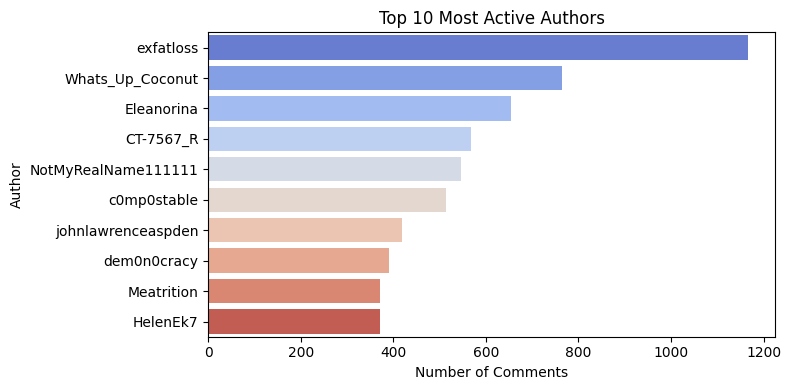

In [13]:
top_authors = (
    df.dropna(subset=["Theme", "author"])
    .groupby("author")
    .size()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(8, 4))
sns.barplot(x=top_authors.values, y=top_authors.index, palette="coolwarm")
plt.xlabel("Number of Comments")
plt.ylabel("Author")
plt.title("Top 10 Most Active Authors")
plt.tight_layout()
plt.show()


In [18]:
from collections import defaultdict

# Get top N authors per theme
top_authors_per_theme = defaultdict(list)
themes = df["Theme"].dropna().unique()

for theme in themes:
    theme_df = df[df["Theme"] == theme]
    top_authors = theme_df["author"].value_counts().head(5)
    for author, count in top_authors.items():
        top_authors_per_theme[theme].append((author, count))

# Convert to DataFrame for display
rows = []
for theme, authors in top_authors_per_theme.items():
    for author, count in authors:
        rows.append({"Theme": theme, "Author": author, "Comment Count": count})

top_authors_theme_df = pd.DataFrame(rows)
top_authors_theme_df

,Theme,Author,Comment Count
0,Community Building,Divinakra,51
1,Community Building,Fresh-Wishbone-5557,51
2,Community Building,CT-7567_R,47
3,Community Building,Tripoteur,44
4,Community Building,c0mp0stable,40
5,General Diet and Nutrition Discussion,exfatloss,318
6,General Diet and Nutrition Discussion,Whats_Up_Coconut,193
7,General Diet and Nutrition Discussion,Eleanorina,155
8,General Diet and Nutrition Discussion,NotMyRealName111111,123
9,General Diet and Nutrition Discussion,partlyPaleo,90


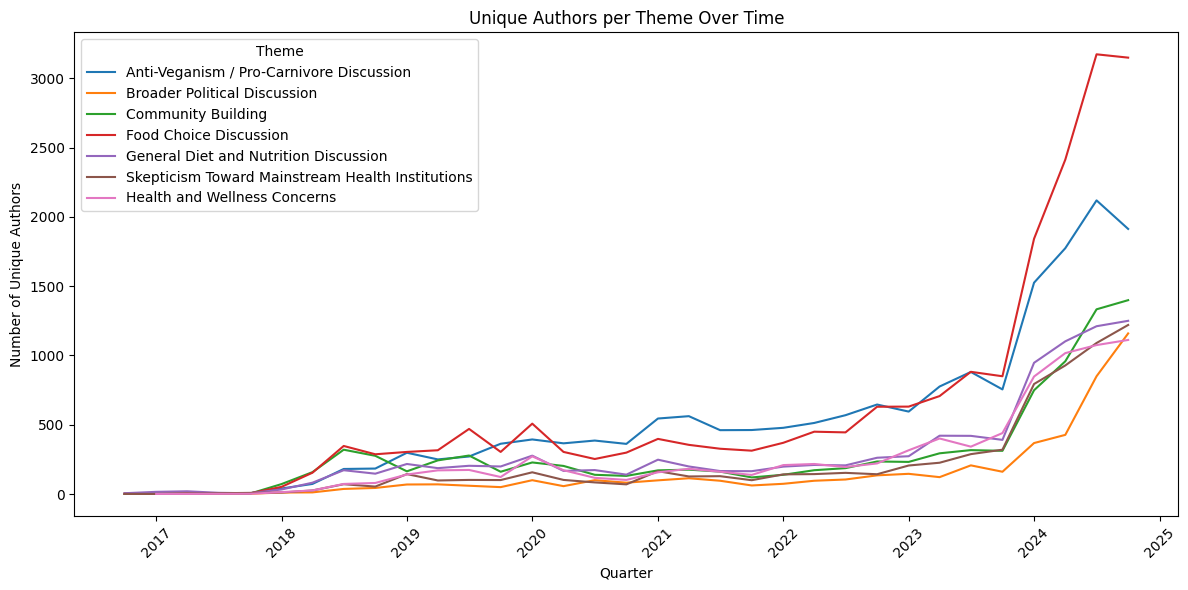

In [15]:
df["quarter"] = df["Timestamp"].dt.to_period("Q").dt.to_timestamp()

authors_over_time = (
    df.dropna(subset=["Theme", "author"])
    .groupby(["quarter", "Theme"])["author"]
    .nunique()
    .reset_index(name="unique_authors")
)

plt.figure(figsize=(12, 6))
sns.lineplot(data=authors_over_time, x="quarter", y="unique_authors", hue="Theme", palette="tab10")
plt.title("Unique Authors per Theme Over Time")
plt.xlabel("Quarter")
plt.ylabel("Number of Unique Authors")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [17]:
# THEME: Change sample size, topic number and random_state as needed
sampled_docs = df[df["Theme"] == "Food Choice Discussion"]["Document"].sample(10, random_state=0)


for i, doc in enumerate(sampled_docs, 1):
    print(f"{i}. {doc}\n")


1. Macadamia oil? But then there's the Oleic Acid concern.

2. Caffeine + Aspirin. Cheaper and the safety profile is well known. Check out Geri-care aspirin for a pure option.

3. Or because of vaporization? Lol

4. Plants have a vested interest in their seeds not being destroyed, so there are cyanogenic glycosides and a whole host of anti-nutrients that either inhibit normal digestive function such as disabling proteases, binding to nutrients and preventing absorption, compounds that irritate the gut lining which reduce nutrient absorption in a different pathway, compounds that interfere with thyroid function by inhibiting iodine uptake, etc. I am a bit biased as I used to work in environmental analytics as a project chemist for much longer than I should have. One thing that stood out to me in that chapter of my life was how masterfully our focus was moved from things that would harm industry toward the more benign. While I do not know if those studying food and nutrition related scie

In [48]:
# Topics that make up the Food Choice Discussion theme
food_choice_topics = [0, 18, 19, 20, 21, 22, 23, 25, 29, 30, 33, 34, 40, 41, 42, 44, 45, 46, 53, 57, 65, 66, 99, 132, 133]

# Filter df to only include documents in this theme
food_df = df[df["Topic"].isin(food_choice_topics)]

In [49]:
# Count of documents per topic per quarter
topic_counts = food_df.groupby(["Timestamp", "Topic"]).size().reset_index(name="Count")

In [50]:
topic_labels = {
    0: "Seed oils",
    18: "Coffee",
    19: "Beef liver",
    20: "Eggs",
    21: "Raw milk",
    22: "Collagen/Soy",
    23: "Potatoes",
    25: "Butter",
    29: "Fish",
    30: "Chicken",
    # add remaining labels as needed...
}


In [51]:
# Step 2: Filter for Food Choice theme and map labels
food_df = df[df["Topic"].isin(food_choice_topics)].copy()
food_df["Label"] = food_df["Topic"].map(topic_labels)

# Step 3: Convert Timestamp to quarterly format
food_df["Quarterly"] = food_df["Timestamp"].dt.to_period("Q").dt.to_timestamp()

# Step 4: Get top 10 most common topics
top10 = (
    food_df["Label"]
    .value_counts()
    .nlargest(10)
    .index
)
food_df = food_df[food_df["Label"].isin(top10)]

In [52]:
food_df

,comment_id,Document,Topic,Timestamp,quarter,score,Theme,author,depth,Label,Quarterly
Quarter,,,,,,,,,,,
2024-04-01,l39knl4,Awesome! So no need of a liver transplant?,19,2024-05-09 11:14:18,2024Q2,2.0,Food Choice Discussion,OldSoul754,0.0,Beef liver,2024-04-01
2024-04-01,l3a8cyt,I don't know exactly O something 🤔 I eat only ...,22,2024-05-09 14:09:50,2024Q2,1.0,Food Choice Discussion,Done-with-work,1.0,Collagen/Soy,2024-04-01
2024-04-01,l38fw1h,Kidney? Find a butcher. They're always cheap. ...,19,2024-05-09 03:39:29,2024Q2,4.0,Food Choice Discussion,NaN,2.0,Beef liver,2024-04-01
2024-04-01,l39856z,Wow that’s crazy I been sneezing & stuff After...,30,2024-05-09 08:50:07,2024Q2,2.0,Food Choice Discussion,Accomplished_Way1028,4.0,Chicken,2024-04-01
2024-04-01,l3b744m,Can you try to eat the eggs runny or completel...,20,2024-05-09 17:35:17,2024Q2,1.0,Food Choice Discussion,NaN,6.0,Eggs,2024-04-01
...,...,...,...,...,...,...,...,...,...,...,...
2024-10-01,lyn4v58,Ace k is not good,0,2024-11-23 21:42:25,2024Q4,1.0,Food Choice Discussion,OkSeaworthiness9971,3.0,Seed oils,2024-10-01
2024-04-01,l3z1l4h,Rice and bread.,22,2024-05-14 08:08:23,2024Q2,1.0,Food Choice Discussion,learnedhelplessness_,2.0,Collagen/Soy,2024-04-01
2024-04-01,l3vuz39,Okey thank you! My problem with dairy is autoi...,21,2024-05-13 18:13:50,2024Q2,1.0,Food Choice Discussion,selfud,3.0,Raw milk,2024-04-01


In [53]:
# Step 5: Count by quarter and topic
topic_over_time = (
    food_df.groupby(["Quarterly", "Label"])
    .size()
    .reset_index(name="Count")
)

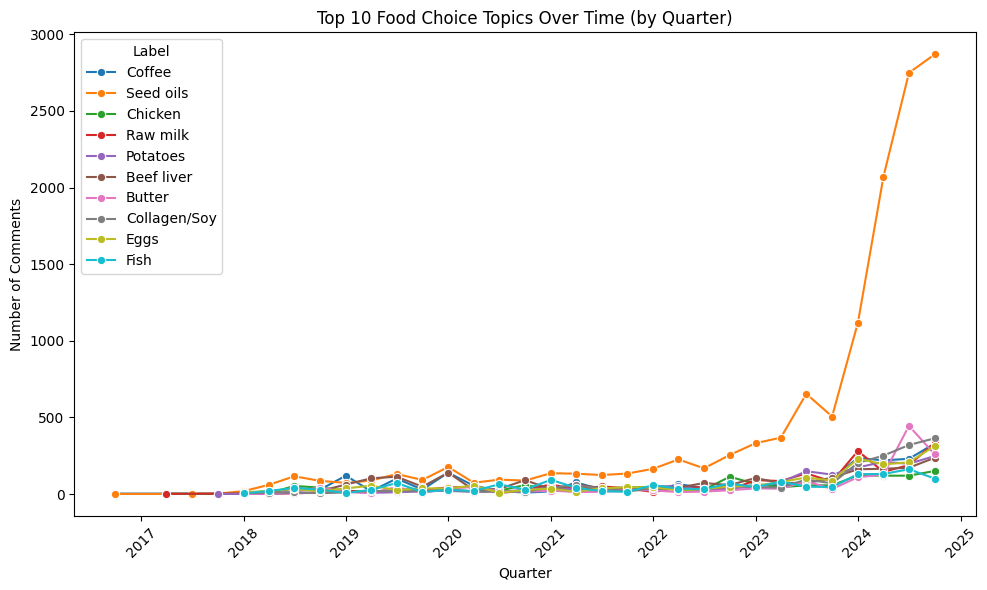

In [59]:
# Step 6: Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=topic_over_time, x="Quarterly", y="Count", hue="Label", marker="o")
plt.title("Top 10 Food Choice Topics Over Time (by Quarter)")
plt.xlabel("Quarter")
plt.ylabel("Number of Comments")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

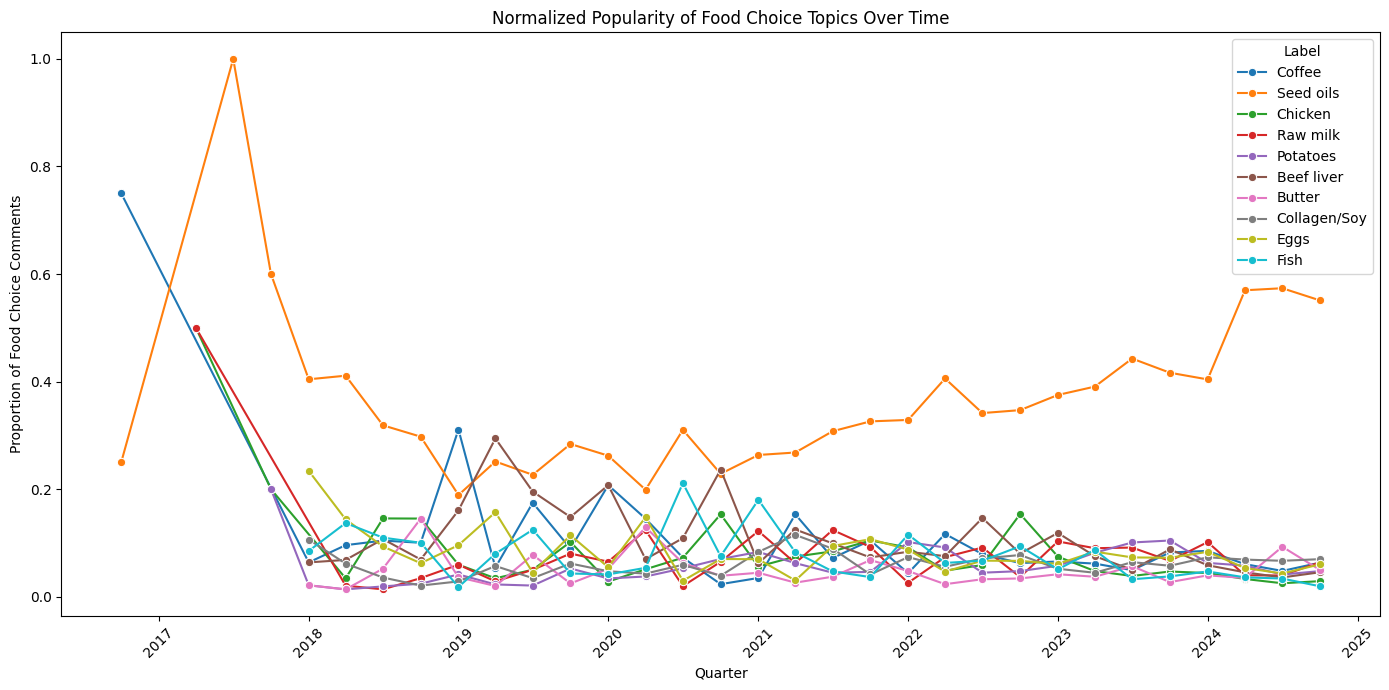

In [55]:
# Step 1: Get total number of comments per quarter (for normalization)
total_per_quarter = (
    food_df.groupby("Quarterly")
    .size()
    .reset_index(name="Total")
)

# Step 2: Count topic mentions per quarter
topic_counts = (
    food_df.groupby(["Quarterly", "Label"])
    .size()
    .reset_index(name="Count")
)

# Step 3: Merge to get total per quarter
topic_counts = topic_counts.merge(total_per_quarter, on="Quarterly")

# Step 4: Normalize counts (proportion of comments per quarter)
topic_counts["Proportion"] = topic_counts["Count"] / topic_counts["Total"]

# Step 5: Plot
plt.figure(figsize=(14, 7))
sns.lineplot(data=topic_counts, x="Quarterly", y="Proportion", hue="Label", marker="o")
plt.title("Normalized Popularity of Food Choice Topics Over Time")
plt.xlabel("Quarter")
plt.ylabel("Proportion of Food Choice Comments")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
